In [43]:
import os
import re
import torch
import pandas as pd
import numpy as np
import evaluate
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pickle
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Apply tqdm to all .apply() functions by using progress_apply
tqdm.pandas()


# ============
# Define device
# ============
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA GPU (CUDA)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Mac GPU (MPS)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Mac GPU (MPS)


In [44]:
# ============
# Helper Functions and Definitions for the LSTM with Attention model
# ============

# (Re)define the special tokens (make sure these match what was used during training)
PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN = "<PAD>", "<SOS>", "<EOS>", "<UNK>"


# Load the vocab dictionary from 'vocab.pkl'
with open('../saved_models/lstm/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)


# Build reverse vocabulary for decoding token ids back to words.
reverse_vocab = {idx: word for word, idx in vocab.items()}

# Maximum sequence lengths (use the same values as in training)
MAX_ARTICLE_LEN = 400
MAX_SUMMARY_LEN = 100

# Text cleaning and tokenization function for the LSTM model:
def text_to_sequence(text, max_len, add_eos=False):
    words = text.lower().split()
    if add_eos:
        words = words + [EOS_TOKEN]  # append EOS
    # Truncate if too long
    if len(words) > max_len:
        words = words[:max_len]
        if add_eos and words[-1] != EOS_TOKEN:
            words[-1] = EOS_TOKEN  # ensure it ends with EOS if truncated
    # Convert to ids, use UNK if not in vocab
    seq = [vocab.get(w, vocab[UNK_TOKEN]) for w in words]
    # Pad sequence to max_len with PAD token
    if len(seq) < max_len:
        seq += [vocab[PAD_TOKEN]] * (max_len - len(seq))
    return seq

# Define a greedy decoding function for your custom LSTM with attention.
def generate_summary_lstm(article_text, encoder, decoder, max_article_len, max_summary_len):
    # Convert the input article text to sequence form.
    seq = text_to_sequence(article_text, max_article_len, add_eos=False)
    src_tensor = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(device)
    
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        enc_outputs, hidden, cell = encoder(src_tensor)
        # Start with the SOS token.
        dec_input = torch.tensor([vocab[SOS_TOKEN]], dtype=torch.long).to(device)
        generated_tokens = []
        for t in range(max_summary_len):
            output, hidden, cell, _ = decoder(dec_input, hidden, cell, enc_outputs)
            top1 = output.argmax(1)
            if top1.item() == vocab[EOS_TOKEN]:
                break
            generated_tokens.append(top1.item())
            dec_input = top1
    
    # Convert token ids to words.
    generated_text = " ".join([reverse_vocab.get(idx, UNK_TOKEN) for idx in generated_tokens])
    return generated_text

In [45]:
# ============
# Load the Test Dataset
# =============
test_df = pd.read_csv('../data/cnn_dailymail/test.csv')
print("Number of test records:", len(test_df))


# Running all the cleaning/preprocessing routines on test_df here
test_df  = test_df.sample(frac=0.05, random_state=42).reset_index(drop=True)
print("Testing samples:", len(test_df))


# Function to remove prefixes from the article text
def clean_prefix(text):
    # Remove news source prefixes (with or without location)
    # This pattern matches an optional location (letters, spaces, commas)
    # followed by a parenthesized news source.
    text = re.sub(r'^(?:[\w\s,]+)?\s*\(\s*[A-Za-z. ]+\s*\)\s*', '', text)
    
    # Remove full publication info starting with "By . Associated Press" followed by publication details.
    # The non-greedy ".*?" will catch everything until the final period of the prefix.
    text = re.sub(r'^By\s*\.\s*Associated\s+Press\s*\..*?UPDATED:\s*\..*?\.\s*', '', text, flags=re.DOTALL)
    
    # Remove publication info starting directly with "PUBLISHED:"
    text = re.sub(r'^PUBLISHED:\s*\..*?UPDATED:\s*\..*?\.\s*', '', text, flags=re.DOTALL)

    # Normalize whitespace
    text = ' '.join(text.split())
    
    return text

# Apply cleaning to articles
test_df['article'] = test_df['article'].progress_apply(lambda x: clean_prefix(str(x)))


# Function to clean text
def clean_text(text):
    # Remove HTML tags (anything between < and >)
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove URLs (matches http://, https://, or www.)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove newline characters (replace them with a space)
    text = re.sub(r'\n+', ' ', text)
    
    # Remove extra spaces: replace any sequence of whitespace with a single space and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning to articles
test_df['article'] = test_df['article'].progress_apply(lambda x: clean_text(str(x)))

Number of test records: 11490
Testing samples: 574


100%|██████████| 574/574 [00:00<00:00, 5896.60it/s]


In [46]:
# Missing value check
print("Missing in articles:", test_df['article'].isnull().sum())
print("Missing in highlights:", test_df['highlights'].isnull().sum())

Missing in articles: 0
Missing in highlights: 0


### ----- Custom LSTM with Attention -----

In [47]:
# Encoder: LSTM
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, enc_hidden_dim):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab[PAD_TOKEN])
        self.lstm = nn.LSTM(embed_dim, enc_hidden_dim, batch_first=True)
    def forward(self, src_sequences):
        # src_sequences: [batch_size, seq_len]
        embedded = self.embedding(src_sequences)            # [batch, seq_len, embed_dim]
        outputs, (hidden, cell) = self.lstm(embedded)       # outputs: [batch, seq_len, enc_hidden_dim]
        # hidden: [1, batch, enc_hidden_dim] (1 layer), cell: [1, batch, enc_hidden_dim]
        return outputs, hidden, cell

# Attention module (additive attention)
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim, attn_dim):
        super(Attention, self).__init__()
        # We create layers to compute alignment scores
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, attn_dim)
        self.v = nn.Linear(attn_dim, 1, bias=False)
    def forward(self, dec_hidden, enc_outputs):
        # dec_hidden: [batch, dec_hidden_dim]
        # enc_outputs: [batch, src_len, enc_hidden_dim]
        batch_size = enc_outputs.size(0)
        src_len = enc_outputs.size(1)
        # Repeat decoder hidden state across all timesteps to concat with encoder outputs
        dec_hidden_exp = dec_hidden.unsqueeze(1).repeat(1, src_len, 1)   # [batch, src_len, dec_hidden_dim]
        # Concatenate decoder hidden and encoder outputs
        concat = torch.cat((enc_outputs, dec_hidden_exp), dim=2)         # [batch, src_len, enc_hidden_dim+dec_hidden_dim]
        # Compute energy scores
        energy = torch.tanh(self.attn(concat))                          # [batch, src_len, attn_dim]
        scores = self.v(energy).squeeze(2)                              # [batch, src_len]
        # Compute attention weights
        attn_weights = torch.softmax(scores, dim=1)                     # [batch, src_len]
        # Weighted sum of encoder outputs
        context = torch.bmm(attn_weights.unsqueeze(1), enc_outputs).squeeze(1)  # [batch, enc_hidden_dim]
        return context, attn_weights

# Decoder: LSTM with attention
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, enc_hidden_dim, dec_hidden_dim, attention):
        super(Decoder, self).__init__()
        self.attention = attention
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab[PAD_TOKEN])
        # LSTM will take concatenated [embedded_word, context] as input features
        self.lstm = nn.LSTM(enc_hidden_dim + embed_dim, dec_hidden_dim, batch_first=True)
        # Output layer: takes [decoder_hidden, context, embedded_input] to predict next token
        self.fc_out = nn.Linear(enc_hidden_dim + dec_hidden_dim + embed_dim, vocab_size)
    def forward(self, input_token, hidden, cell, enc_outputs):
        # input_token: [batch] (indices of current word input to decoder)
        embedded = self.embedding(input_token).unsqueeze(1)         # [batch, 1, embed_dim]
        # Use last hidden state of decoder (hidden is [1,batch,dec_hidden]; use hidden[0] since 1 layer)
        dec_hidden = hidden[-1]  # [batch, dec_hidden_dim]
        # Compute attention to get context vector
        context, attn_weights = self.attention(dec_hidden, enc_outputs)  # context: [batch, enc_hidden_dim]
        context = context.unsqueeze(1)                                   # [batch, 1, enc_hidden_dim]
        # Prepare LSTM input by concatenating context with embedded current word
        lstm_input = torch.cat((embedded, context), dim=2)          # [batch, 1, embed_dim+enc_hidden_dim]
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        # Now output is [batch, 1, dec_hidden_dim]
        output = output.squeeze(1)     # [batch, dec_hidden_dim]
        context = context.squeeze(1)   # [batch, enc_hidden_dim]
        embedded = embedded.squeeze(1) # [batch, embed_dim]
        # Compute final output distribution over vocabulary
        pred_input = torch.cat((output, context, embedded), dim=1)   # [batch, enc_hidden_dim+dec_hidden_dim+embed_dim]
        preds = self.fc_out(pred_input)                             # [batch, vocab_size]
        return preds, hidden, cell, attn_weights


# Reconstruct the LSTM model with the same architecture parameters as used in training:
vocab_size = len(vocab)
embed_dim = 128
enc_hidden_dim = 256
dec_hidden_dim = 256
attn_dim = 256

encoder_lstm = Encoder(vocab_size, embed_dim, enc_hidden_dim)
attn = Attention(enc_hidden_dim, dec_hidden_dim, attn_dim)
decoder_lstm = Decoder(vocab_size, embed_dim, enc_hidden_dim, dec_hidden_dim, attn)


# Load the saved checkpoint (make sure the file path matches)
checkpoint = torch.load("../saved_models/lstm/best_model.pth", map_location=device)
encoder_lstm.load_state_dict(checkpoint['encoder_state_dict'])
decoder_lstm.load_state_dict(checkpoint['decoder_state_dict'])
encoder_lstm.to(device)
decoder_lstm.to(device)
print("Loaded LSTM with Attention model.")

Loaded LSTM with Attention model.


### ----- T5-small Finetuned with LoRA -----

In [48]:
tokenizer_t5 = AutoTokenizer.from_pretrained("t5-small")
model_t5 = AutoModelForSeq2SeqLM.from_pretrained("../saved_models/t5-small-lora/best_model")
model_t5.to(device)
print("Loaded T5-small LoRA model.")

def generate_summary_t5(article_text, model, tokenizer, max_input_length=512, max_output_length=128):
    input_text = "summarize: " + article_text
    inputs = tokenizer(input_text, return_tensors="pt", max_length=max_input_length, truncation=True).to(device)
    summary_ids = model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], max_length=max_output_length)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

Loaded T5-small LoRA model.


### ----- BART-large-cnn Finetuned with LoRA -----

In [49]:
tokenizer_bart = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model_bart = AutoModelForSeq2SeqLM.from_pretrained("../saved_models/bart-large-cnn-lora/best_model")
model_bart.to(device)
print("Loaded BART-large-cnn LoRA model.")

def generate_summary_bart(article_text, model, tokenizer, max_input_length=1024, max_output_length=128):
    inputs = tokenizer(article_text, return_tensors="pt", max_length=max_input_length, truncation=True).to(device)
    summary_ids = model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], max_length=max_output_length)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

Loaded BART-large-cnn LoRA model.


## Evaluation
1. **ROUGE (Recall-Oriented Understudy for Gisting Evaluation):** ROUGE is a set of metrics that measure the overlap between the generated summary (candidate) and the human-written summary (reference). Summaries need to capture the important content of the original article. ROUGE effectively quantifies how much of the reference content is present in the generated summary. ROUGE is the most commonly reported metric in summarization research, so tracking it allows you to compare your system’s performance with state-of-the-art methods. Different ROUGE variants (such as ROUGE-1 vs. ROUGE-L) provide multiple perspectives on content overlap and coherence. The common variants include:
    - ROUGE-1: Measures overlap of single words (unigrams).
    - ROUGE-2: Measures overlap of consecutive two-word sequences (bigrams).
    - ROUGE-L: Based on the longest common subsequence (LCS) which considers sentence-level structure in the matching process.
2. **BLEU (Bilingual Evaluation Understudy):** BLEU is an n-gram based metric traditionally used in machine translation. It calculates the precision of n-gram overlap between the generated text and one or more references, while applying a brevity penalty to account for short outputs. Although originally designed for translation, BLEU can serve as an additional signal in summarization. It measures how precisely the generated summary matches the reference in terms of word sequences. While ROUGE focuses more on recall (what proportion of reference content is captured), BLEU emphasizes precision (how much of the generated text is relevant). This complementary view can help you balance content completeness with output fluency. It provides another quantitative measure that, together with ROUGE, can help diagnose strengths and weaknesses in your model outputs.
3. **BERTScore:** BERTScore leverages contextual embeddings (typically from BERT or similar models) to compare candidate summaries with reference summaries. Instead of merely counting surface-level n-gram matches, it computes similarity scores based on semantic representations. The metric produces precision, recall, and F1 scores. BERTScore is less sensitive to exact word overlap and more to meaning. This is particularly useful in summarization where different wordings or synonyms may convey the same idea. Because it uses deep representations, BERTScore can capture nuances in meaning that surface-level metrics like ROUGE and BLEU might miss. Research has shown that BERTScore often correlates better with human evaluations of text quality, making it a valuable metric for assessing the overall quality of generated summaries.

In [50]:
# Initialize the ROUGE (and other) metrics using the Hugging Face evaluate library.
rouge_metric = evaluate.load("rouge")
bleu_metric = evaluate.load("bleu")
bertscore_metric = evaluate.load("bertscore")

In [51]:
lstm_preds = []
t5_preds = []
bart_preds = []
references = []

# Function to Generate summaries for the test set
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Generating summaries"):
    article = row["article"]
    reference = row["highlights"]
    references.append(reference)
    
    # Generate predictions.
    lstm_prediction = generate_summary_lstm(article, encoder_lstm, decoder_lstm, MAX_ARTICLE_LEN, MAX_SUMMARY_LEN)
    lstm_preds.append(lstm_prediction)
    
    t5_prediction = generate_summary_t5(article, model_t5, tokenizer_t5)
    t5_preds.append(t5_prediction)
    
    bart_prediction = generate_summary_bart(article, model_bart, tokenizer_bart)
    bart_preds.append(bart_prediction)

    # # (Optional: Limit to first N examples to speed up evaluation during experimentation)
    # if idx >= 49:  # For example, evaluate on 50 examples.
    #     break

Generating summaries:   0%|          | 0/574 [00:00<?, ?it/s]

Generating summaries: 100%|██████████| 574/574 [1:14:52<00:00,  7.83s/it]


In [52]:
print("Number of references:", len(references))
print("Number of T5 predictions:", len(t5_preds))
print("Number of LSTM predictions:", len(lstm_preds))
print("Number of BART predictions:", len(bart_preds))

Number of references: 574
Number of T5 predictions: 574
Number of LSTM predictions: 574
Number of BART predictions: 574


In [53]:
# Compute ROUGE scores.
rouge_lstm = rouge_metric.compute(predictions=lstm_preds, references=references)
rouge_t5 = rouge_metric.compute(predictions=t5_preds, references=references)
rouge_bart = rouge_metric.compute(predictions=bart_preds, references=references)

print("\n--- ROUGE Scores ---")
print("LSTM with Attention:", rouge_lstm)
print("T5-small with LoRA:", rouge_t5)
print("BART-large-cnn with LoRA:", rouge_bart)


--- ROUGE Scores ---
LSTM with Attention: {'rouge1': np.float64(0.021620269060809865), 'rouge2': np.float64(0.002044189955550322), 'rougeL': np.float64(0.019138499521143187), 'rougeLsum': np.float64(0.020590187108777278)}
T5-small with LoRA: {'rouge1': np.float64(0.3837183326531864), 'rouge2': np.float64(0.17272069132985146), 'rougeL': np.float64(0.27308504156666835), 'rougeLsum': np.float64(0.33402098529494706)}
BART-large-cnn with LoRA: {'rouge1': np.float64(0.4181146602081973), 'rouge2': np.float64(0.19283284059866396), 'rougeL': np.float64(0.27858412592712506), 'rougeLsum': np.float64(0.3888858906577949)}


In [54]:
# Compute BLEU scores using raw string input.
bleu_lstm = bleu_metric.compute(predictions=lstm_preds,
                                references=[[ref] for ref in references])
bleu_t5 = bleu_metric.compute(predictions=t5_preds,
                              references=[[ref] for ref in references])
bleu_bart = bleu_metric.compute(predictions=bart_preds,
                                references=[[ref] for ref in references])

print("\n--- BLEU Scores ---")
print("LSTM with Attention:", bleu_lstm)
print("T5-small with LoRA:", bleu_t5)
print("BART-large-cnn with LoRA:", bleu_bart)


--- BLEU Scores ---
LSTM with Attention: {'bleu': 0.0, 'precisions': [0.0191115340311514, 0.0004533502584096473, 5.066523452937064e-05, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 3.058670343137255, 'translation_length': 99835, 'reference_length': 32640}
T5-small with LoRA: {'bleu': 0.14431086511629718, 'precisions': [0.4296462467644521, 0.19031020034505827, 0.114169691307004, 0.07705573698308443], 'brevity_penalty': 0.8811844134954571, 'length_ratio': 0.8877144607843137, 'translation_length': 28975, 'reference_length': 32640}
BART-large-cnn with LoRA: {'bleu': 0.15103856715241268, 'precisions': [0.3925831839011755, 0.17721966749204104, 0.1052968926263973, 0.07103825136612021], 'brevity_penalty': 1.0, 'length_ratio': 1.2301470588235295, 'translation_length': 40152, 'reference_length': 32640}


In [55]:
# Compute BERTScore.
bertscore_lstm = bertscore_metric.compute(predictions=lstm_preds, references=references, lang="en")
bertscore_t5 = bertscore_metric.compute(predictions=t5_preds, references=references, lang="en")
bertscore_bart = bertscore_metric.compute(predictions=bart_preds, references=references, lang="en")

print("\n--- BERTScore (F1) ---")
print("LSTM with Attention: {:.4f}".format(np.mean(bertscore_lstm["f1"])))
print("T5-small with LoRA: {:.4f}".format(np.mean(bertscore_t5["f1"])))
print("BART-large-cnn with LoRA: {:.4f}".format(np.mean(bertscore_bart["f1"])))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- BERTScore (F1) ---
LSTM with Attention: 0.7286
T5-small with LoRA: 0.8742
BART-large-cnn with LoRA: 0.8852


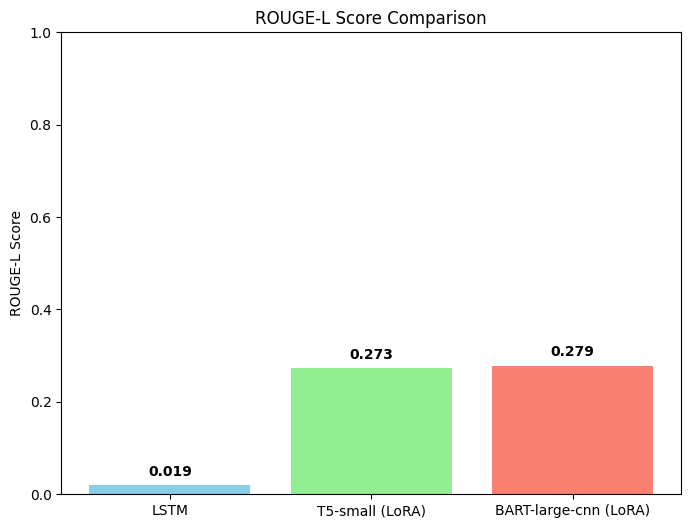

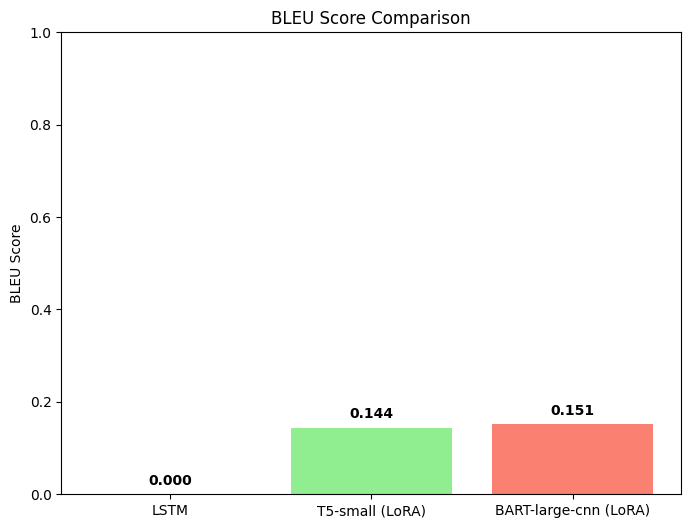

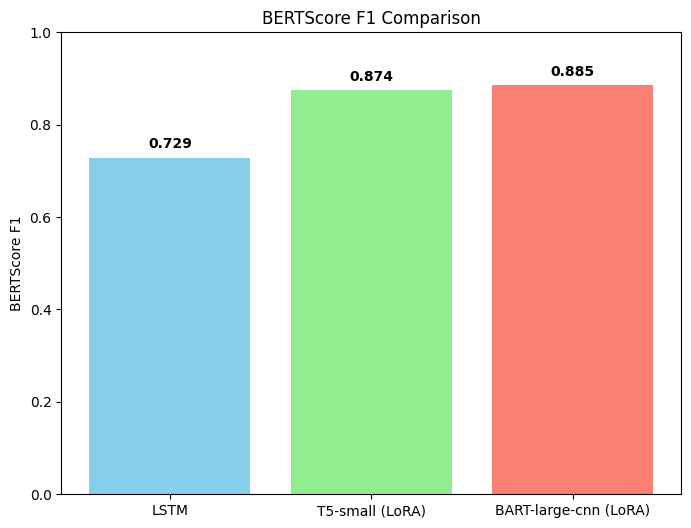

In [56]:
# Organize the metrics into dictionaries for convenience.
rouge_scores = {
    "LSTM": rouge_lstm.get("rougeL", 0.0),
    "T5-small (LoRA)": rouge_t5.get("rougeL", 0.0),
    "BART-large-cnn (LoRA)": rouge_bart.get("rougeL", 0.0),
}

bleu_scores = {
    "LSTM": bleu_lstm.get("bleu", 0.0),
    "T5-small (LoRA)": bleu_t5.get("bleu", 0.0),
    "BART-large-cnn (LoRA)": bleu_bart.get("bleu", 0.0),
}

bertscore_scores = {
    "LSTM": np.mean(bertscore_lstm["f1"]),
    "T5-small (LoRA)": np.mean(bertscore_t5["f1"]),
    "BART-large-cnn (LoRA)": np.mean(bertscore_bart["f1"]),
}

# ---- Plot 1: ROUGE-L Scores ----
plt.figure(figsize=(8,6))
models = list(rouge_scores.keys())
scores = list(rouge_scores.values())
plt.bar(models, scores, color=['skyblue','lightgreen','salmon'])
plt.title("ROUGE-L Score Comparison")
plt.ylabel("ROUGE-L Score")
plt.ylim(0, 1)
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')
plt.show()

# ---- Plot 2: BLEU Scores ----
plt.figure(figsize=(8,6))
models = list(bleu_scores.keys())
scores = list(bleu_scores.values())
plt.bar(models, scores, color=['skyblue','lightgreen','salmon'])
plt.title("BLEU Score Comparison")
plt.ylabel("BLEU Score")
plt.ylim(0, 1)
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')
plt.show()

# ---- Plot 3: BERTScore F1 Comparison ----
plt.figure(figsize=(8,6))
models = list(bertscore_scores.keys())
scores = list(bertscore_scores.values())
plt.bar(models, scores, color=['skyblue','lightgreen','salmon'])
plt.title("BERTScore F1 Comparison")
plt.ylabel("BERTScore F1")
plt.ylim(0, 1)
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')
plt.show()